# Neural-based channel decoders


## 1. Prerequisites:  

The purpose of this part of the work is to compare the BER of both a pre-trained neural decoder and the MAP decoder for a Polar code over an AWGN channel. 

In order to develop a neural based channel decoder you will need: 

- A communication chain which implements the polar code and its MAP decoder (under python)
- A working keras environment with the proper backend Tensorflow 


## 2. Training dataset and training:  

In order to train the neural network, you need to provide it with both: 
- Input sequences: the received $y^n$
- Label sequences (or targets) : the transmitted $u^k$

In order for the neural decoder to be able to recover the original information words, i.e., $u^k$, the neural decoder needs to be trained over all possible $u^k$ and therefore, all posssible codewords $c^n$. Thus, the label sequences need to cover all possibly transmitted sequences. 

The labels can be coded in two different manners: 
- Array representation: the output of the neural network is a vector of size k, which outputs for each bit $i \in [1:k]$, a possible value 0 or 1. . 
- One hot representation: the output of the neural networ is a vector of size $2^k$ which outputs $1$ only at the index of the information word transmitted, and 0 everywhere else. 

Question: In practice, the output of a neural network is never binary, but it rather has a soft value $ \in [0:1]$. Depending on the type of the network, two possible output activation functions can be used in order to output these soft values: sigmoid or softmax. Which function should we use for either strategies? 

In this project, we will use one-hot representations. 

## 3. Testing: 
Once the neural network is trained, you can test it in the communication chain you implemented before. 

## 4. Design meta-parameters: 

The performances of the neural decoder will be strongly related to the metaparameters chosen during training. 

Try and assess the effect of the different design metaparameters: 

- Training epochs
- Number of hidden layers
- Number of neurons per layer
- Activation functions
- Training SNR 
- Optimizer 
- Loss function: mse, crossentropy 


In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber

# Configuration
MODULATION = 'BPSK'
G = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# Initialization
transmitter = Transmitter(MODULATION, G)
channel = AWGNChannel(MODULATION, G)
receiver = Receiver(MODULATION, G, ReceiverMode.MAP)

if __name__ == '__main__':
    # receiver.block_elements contains all possible u^k (labels)
    # receiver.block_coded_elements contains all possible codewords c^n
    
    k = np.size(G, 0)
    n = np.size(G, 1)
    
    # Create model
    hot_model=Sequential()
    hot_model.add(Dense(10*2**k, activation='sigmoid', input_dim=n))
    hot_model.add(Dense(2**k, activation='sigmoid', input_dim=n))
    hot_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(hot_model.summary())

    # Create labels for hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    hot_history = hot_model.fit(
        np.array(receiver.block_coded_elements), 
        np.array(labels), 
        epochs=10**4, 
        verbose=0
    )


Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2560)              43520     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               655616    
Total params: 699,136
Trainable params: 699,136
Non-trainable params: 0
_________________________________________________________________
None










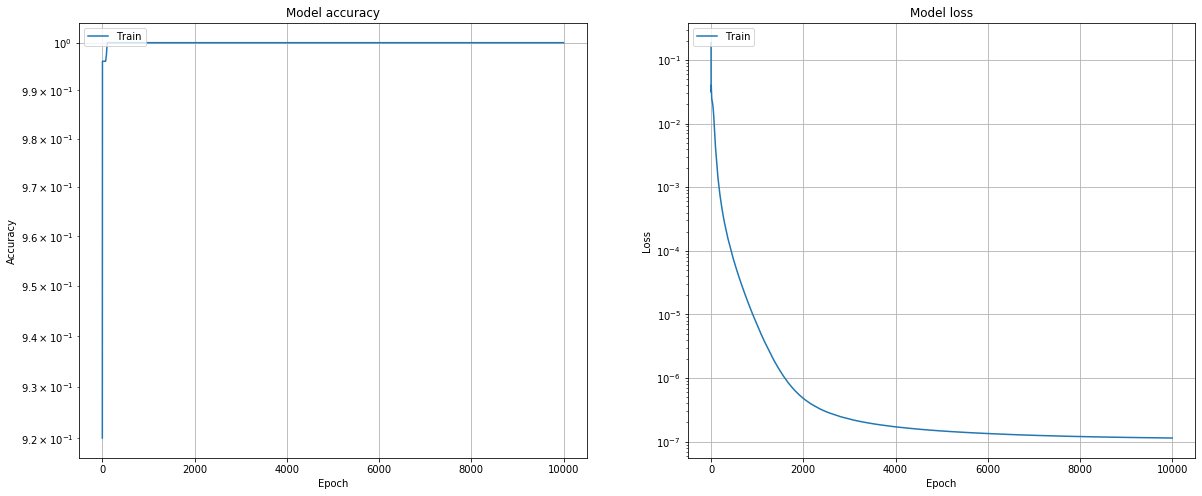

In [4]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
plt.grid()
plt.plot(hot_history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(122)
plt.grid()
plt.plot(hot_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.yscale('log')
# plt.subplots_adjust(wspace = 0.5)